<a href="https://colab.research.google.com/github/simon108018/Machine-Learning/blob/master/InceptionV3(run_tflit_with_int).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
assert float(tf.__version__[:3]) >= 2.3

#tfds.list_builders()

In [3]:
# 資料處理
test_data, info = tfds.load("cifar10", split="test", with_info=True)

In [6]:
# 定義圖像縮放
def parse_aug_fn(dataset):
    def zoom(x, sh = 299, sw = 299):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    # y = tf.one_hot(dataset['label'], 10)
    y = dataset['label']
    
    return x, y

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [8]:
test_data_np = tfds.as_numpy(test_data)
test_images = []
test_labels = []
for data in test_data_np:
  test_images.append(data[0])
  test_labels.append(data[1])

In [9]:
# tflite檔案路徑
import pathlib
tflite_models_dir = pathlib.Path("/content/drive/My Drive/Colab Notebooks/cifar10/models")
tflite_model_file = tflite_models_dir/"cifar10_model.tflite"
tflite_model_quant_file = tflite_models_dir/"cifar10_model_quant.tflite"

In [10]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [14]:
# Change this to test a different image
test_image_index = 0

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

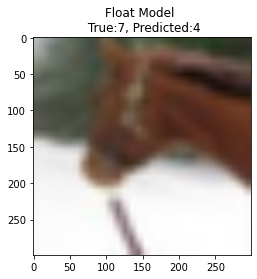

In [25]:
test_model(tflite_model_file, test_image_index, model_type="Float")

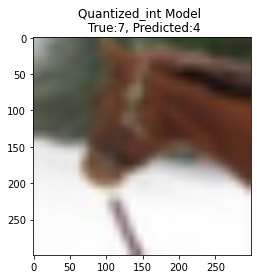

In [16]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized_int")

In [30]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  # test_image_indices = range(test_images.shape[0])
  test_image_indices = range(len(test_images))
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [19]:
import time

In [31]:
tStart = time.time()
evaluate_model(tflite_model_file, model_type="Float")
tEnd = time.time()
print("It cost {m} min {s} sec".format(m=int((tEnd-tStart)/60), s=int((tEnd-tStart)%60)))

Float model accuracy is 84.3900% (Number of test samples=10000)
It cost 40 min 1 sec


In [ ]:
tStart = time.time()
evaluate_model(tflite_model_quant_file, model_type="Quantized")
tEnd = time.time()
print("It cost {m} min {s} sec".format(m=int((tEnd-tStart)/60), s=int((tEnd-tStart)%60)))